# 🏠 Airbnb Scraper

**Eenvoudig notebook voor Airbnb data scraping en visualisatie**

Dit notebook bevat:
- 📋 **Configuratie** - Stel parameters in
- 🚀 **Scraping** - Haal data op
- 📊 **Analyse** - Bekijk statistieken
- 🗺️ **Visualisatie** - Bekijk op kaart

De core functies staan in `src/` folder.


## 📦 Setup & Imports


In [ ]:
# Auto-reload modules (zodat je wijzigingen in src/ meteen ziet)
%load_ext autoreload
%autoreload 2


In [ ]:
import sys
sys.path.insert(0, 'src')

# Core scraping
from src.core import scrape_all, generate_scan_combinations

# Data processing & export  
from src.data import auto_export_results

# Visualization
from src.visualization import create_map, create_availability_timeline_graph

# Utils
from src.utils import setup_logging

# Standard imports
import pandas as pd
import geopandas as gpd
import os
from datetime import datetime

# Setup logging
setup_logging(verbose=VERBOSE if 'VERBOSE' in locals() else False)

## 📋 Configuratie

Je kunt de configuratie op 2 manieren instellen:
1. **Interactief** - Run de volgende cel voor een visuele configurator
2. **Handmatig** - Pas de variabelen in de cel daarna direct aan


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
# CONFIGURATIE - PAS HIER AAN
# ═══════════════════════════════════════════════════════════════════════════════

# Gemeenten
GEMEENTEN = ["Schagen"]

# ═══════════════════════════════════════════════════════════════════════════════
# 📅 PLANNING CONFIGURATIE
# ═══════════════════════════════════════════════════════════════════════════════

PERIOD_START = "2025-06-21"
PERIOD_END = "2025-10-21"

# --- KIES JE PLANNING METHODE ---

# Optie 1: Regulier Interval (simpel)
#   DAYS_OF_WEEK = None
#   MEASUREMENT_INTERVAL = 14  # Elke 14 dagen

# Optie 2: Weekelijks op specifieke dagen
#   DAYS_OF_WEEK = [4, 5, 6]  # Vrijdag + weekend
#   WEEKS_INTERVAL = 1  # Elke week
#   MONTHLY_INTERVAL = False

# Optie 3: Tweewekelijks
#   DAYS_OF_WEEK = [5, 6]  # Weekend
#   WEEKS_INTERVAL = 2  # Elke 2 weken
#   MONTHLY_INTERVAL = False

# Optie 4: Maandelijks (eerste occurrence)
#   DAYS_OF_WEEK = [4]  # Eerste vrijdag
#   MONTHLY_INTERVAL = True

# --- HUIDIGE CONFIGURATIE ---

# 📅 Day-of-Week Filter
# None = Gebruik MEASUREMENT_INTERVAL (reguliere planning)
# [4] = Alleen vrijdag (0=Ma, 1=Di, 2=Wo, 3=Do, 4=Vr, 5=Za, 6=Zo)
# [5, 6] = Alleen weekend (Za+Zo)
# [0, 1, 2, 3, 4] = Alleen weekdagen (Ma-Vr)
DAYS_OF_WEEK = None  # ← Wijzig dit!

# ⏰ Interval Settings (ALLEEN gebruikt als DAYS_OF_WEEK is ingesteld!)
WEEKS_INTERVAL = 1  # 1 = elke week, 2 = elke 2e week, etc.
MONTHLY_INTERVAL = False  # True = eerste occurrence per maand

# 📆 Regulier Interval (ALLEEN gebruikt als DAYS_OF_WEEK = None)
MEASUREMENT_INTERVAL = 30  # ← Tijdelijk hoog (30) voor IP recovery

# Variaties (om alle listings te vangen)
NIGHTS_VARIATIONS = [3, 7]  # Verschillende verblijfslengtes
GUESTS_VARIATIONS = [2]  # Verschillende aantallen gasten

# API instellingen
NUM_REPEAT_CALLS = 3  # Aantal herhaalde calls (voor betere dekking) - VERLAAGD
ZOOM_VALUE = 10
PRICE_MIN = 0
PRICE_MAX = 0
AMENITIES = []
CURRENCY = "EUR"
LANGUAGE = "nl"
PROXY_URL = ""
MAX_WORKERS = 1  # Aantal parallele threads

# ⏱️ RATE LIMIT RECOVERY MODE - Extra conservatief!
# Je IP staat op een "watchlist" - we moeten voorzichtig zijn
DELAY_BETWEEN_SCANS = 3.0  # 🔧 VERHOOGD van 2.0 naar 3.0 seconden
DELAY_BETWEEN_CALLS = 1.5  # 🔧 VERHOOGD van 1.0 naar 1.5 seconden
# Paths
GPKG_PATH = "assets/BestuurlijkeGebieden_2025.gpkg"
DATA_DIR = "outputs/data"
MEASUREMENT_DATE = datetime.now().isoformat()

# Verbosity (set to False for clean progress bar, True for detailed logs)
VERBOSE = False

# Helper voor day-of-week namen
def format_days_of_week(days):
    if days is None:
        return "Alle dagen"
    day_names = ["Ma", "Di", "Wo", "Do", "Vr", "Za", "Zo"]
    return ", ".join([day_names[d] for d in sorted(days)])

def format_interval_mode():
    if DAYS_OF_WEEK is None:
        return f"Elke {MEASUREMENT_INTERVAL} dagen"
    elif MONTHLY_INTERVAL:
        return f"Maandelijks (eerste {format_days_of_week(DAYS_OF_WEEK)})"
    elif WEEKS_INTERVAL > 1:
        return f"Elke {WEEKS_INTERVAL} weken ({format_days_of_week(DAYS_OF_WEEK)})"
    else:
        return f"Elke week ({format_days_of_week(DAYS_OF_WEEK)})"

print("=" * 80)
print("🚀 AIRBNB SCRAPER")
print("=" * 80)
print(f"Meetmoment: {MEASUREMENT_DATE}")
print(f"Periode: {PERIOD_START} → {PERIOD_END}")
print(f"📅 Planning: {format_interval_mode()}")
print(f"Gemeenten: {', '.join(GEMEENTEN)}")
print(f"Verbose logging: {'ON' if VERBOSE else 'OFF'}")
print("=" * 80)

# Preview van geplande meetmomenten
print("\n📅 GEPLANDE MEETMOMENTEN")
print("=" * 80)

# Genereer dummy scan combinaties om de datums te zien
preview_combinations, _ = generate_scan_combinations(
    period_start=PERIOD_START,
    period_end=PERIOD_END,
    nights_list=[1],  # Dummy voor preview
    guests_list=[2],  # Dummy voor preview
    measurement_interval=MEASUREMENT_INTERVAL,
    days_of_week=DAYS_OF_WEEK,
    weeks_interval=WEEKS_INTERVAL,
    monthly_interval=MONTHLY_INTERVAL,
)

# Extract unieke check-in datums
from collections import defaultdict
unique_dates = sorted(list(set([combo[0] for combo in preview_combinations])))

print(f"Totaal {len(unique_dates)} meetdatums:\n")

# Groepeer per maand
from datetime import datetime as dt
months = defaultdict(list)
for date_str in unique_dates:
    date_obj = dt.fromisoformat(date_str).date()
    month_key = date_obj.strftime("%B %Y")
    months[month_key].append(date_obj)

# Print per maand
for month_name, dates in months.items():
    print(f"📆 {month_name}:")
    date_strs = []
    for d in dates:
        day_name = ["Ma", "Di", "Wo", "Do", "Vr", "Za", "Zo"][d.weekday()]
        date_strs.append(f"  • {d.strftime('%d')} ({day_name})")
    print("\n".join(date_strs))
    print()

print("=" * 80)


🚀 AIRBNB SCRAPER
Meetmoment: 2025-10-20T14:25:19.082216
Periode: 2025-06-21 → 2025-10-21
Meet-interval: Elke 14 dagen
Gemeenten: Schagen
Verbose logging: OFF


## 🚀 Run Scraper


In [ ]:
# Genereer scan combinaties
scan_combinations, measurement_dates = generate_scan_combinations(
    period_start=PERIOD_START,
    period_end=PERIOD_END,
    nights_list=NIGHTS_VARIATIONS,
    guests_list=GUESTS_VARIATIONS,
    measurement_interval=MEASUREMENT_INTERVAL,
    days_of_week=DAYS_OF_WEEK,  # 📅 Filter op weekdagen
    weeks_interval=WEEKS_INTERVAL,  # ⏰ Elke N weken
    monthly_interval=MONTHLY_INTERVAL,  # 📆 Maandelijks (eerste occurrence)
)

# Mooie pre-scan samenvatting
print("\n" + "╔" + "═" * 78 + "╗")
print("║" + " 📋 SCAN CONFIGURATIE".center(78) + "║")
print("╠" + "═" * 78 + "╣")
print(f"║  📊 Scan Combinaties:     {len(scan_combinations):,}".ljust(79) + "║")
print(f"║  🛏️  Nachten variaties:    {', '.join(map(str, NIGHTS_VARIATIONS))}".ljust(79) + "║")
print(f"║  👥 Gasten variaties:     {', '.join(map(str, GUESTS_VARIATIONS))}".ljust(79) + "║")
print(f"║  🏘️  Gemeenten:            {', '.join(GEMEENTEN)}".ljust(79) + "║")
print(f"║  🔄 API repeat calls:     {NUM_REPEAT_CALLS}".ljust(79) + "║")
print(f"║  👷 Max workers:          {MAX_WORKERS}".ljust(79) + "║")
print(f"║  ⏱️  Scan delay:           {DELAY_BETWEEN_SCANS}s".ljust(79) + "║")
print("╚" + "═" * 78 + "╝")
print()

# Run scraper
df_all = scrape_all(
    gemeenten=GEMEENTEN,
    scan_combinations=scan_combinations,
    gpkg_path=GPKG_PATH,
    num_repeat_calls=NUM_REPEAT_CALLS,
    zoom_value=ZOOM_VALUE,
    price_min=PRICE_MIN,
    price_max=PRICE_MAX,
    amenities=AMENITIES,
    currency=CURRENCY,
    language=LANGUAGE,
    proxy_url=PROXY_URL,
    measurement_date=MEASUREMENT_DATE,
    max_workers=MAX_WORKERS,
    delay_between_scans=DELAY_BETWEEN_SCANS,     # ⏱️ NIEUW - Rate limit protection
    delay_between_calls=DELAY_BETWEEN_CALLS,     # ⏱️ NIEUW - Rate limit protection
)

# Verzamel config voor opslaan
run_config = {
    "gemeenten": GEMEENTEN,
    "period_start": PERIOD_START,
    "period_end": PERIOD_END,
    "measurement_interval": MEASUREMENT_INTERVAL,
    "nights_variations": NIGHTS_VARIATIONS,
    "guests_variations": GUESTS_VARIATIONS,
    "num_repeat_calls": NUM_REPEAT_CALLS,
    "zoom_value": ZOOM_VALUE,
    "price_min": PRICE_MIN,
    "price_max": PRICE_MAX,
    "amenities": AMENITIES,
    "currency": CURRENCY,
    "language": LANGUAGE,
    "proxy_url": PROXY_URL,
    "gpkg_path": GPKG_PATH,
    "measurement_date": MEASUREMENT_DATE,
}

# Auto-export results (inclusief config)
filename, availability_data, output_dir = auto_export_results(
    df_all,
    period_start=PERIOD_START,
    period_end=PERIOD_END,
    gemeenten=GEMEENTEN,
    data_dir=DATA_DIR,
    config=run_config,
)

# Mooie export samenvatting
print("\n" + "╔" + "═" * 78 + "╗")
print("║" + " ✅ EXPORT VOLTOOID".center(78) + "║")
print("╠" + "═" * 78 + "╣")
print(f"║  📁 Output directory:     {output_dir}".ljust(79) + "║")
print(f"║  📊 Excel bestand:        {filename}".ljust(79) + "║")
print(f"║  🏠 Unieke listings:      {df_all['room_id'].nunique():,}".ljust(79) + "║")
print(f"║  📝 Totaal records:       {len(df_all):,}".ljust(79) + "║")
print("╚" + "═" * 78 + "╝\n")

# Maak automatisch visualisaties
from src.visualization import create_map, create_availability_timeline_graph

# Merge availability data
df_unique = df_all.drop_duplicates('room_id')
df_map = df_unique.merge(
    availability_data[['room_id', 'days_available', 'total_days', 'availability_rate']], 
    on='room_id', 
    how='left'
)

# Laad gemeentegrenzen
import geopandas as gpd
gdf_gemeenten = gpd.read_file(GPKG_PATH, layer="gemeentegebied").set_crs("EPSG:28992").to_crs("EPSG:4326")

# Maak en toon kaart
print("┌" + "─" * 78 + "┐")
print("│" + " 🗺️  INTERACTIEVE KAART".center(78) + "│")
print("└" + "─" * 78 + "┘")
m = create_map(df_map, gdf_gemeenten, GEMEENTEN, output_dir)
display(m)

# Maak en toon timeline grafiek
print("\n┌" + "─" * 78 + "┐")
print("│" + " 📈 BESCHIKBAARHEID TIMELINE".center(78) + "│")
print("└" + "─" * 78 + "┘")
create_availability_timeline_graph(df_all, PERIOD_START, PERIOD_END, output_dir)


📊 Totaal Scan Combinaties: 238
🛏️  Nachten Variaties: [3, 7]
👥 Gasten Variaties: [2]



⚡ Scraping:   0%|          | 0/238 [00:00<?, ?scan/s]WARNING: ⚠️ Rate limit hit (attempt 1/3). Waiting 1.0s...
ERROR: ❌ Rate limit: Too many requests. Reduce workers or increase delays.
ERROR: Failed to make API call: API call failed after 3 attempts
ERROR: ❌ Rate limit: Too many requests. Reduce workers or increase delays.
ERROR: Failed to make API call: API call failed after 3 attempts


##  Laad Eerdere Run (Optioneel)
Als je een eerdere run wilt visualiseren, voer dan deze cel uit.

In [ ]:
# 📂 Selecteer en laad een eerdere run
import os
import glob

# Vind alle run folders
run_folders = sorted(
    [f for f in glob.glob(os.path.join(DATA_DIR, "run_*")) if os.path.isdir(f)],
    key=os.path.getctime,
    reverse=True  # Nieuwste eerst
)

if run_folders:
    print(f"📁 Gevonden runs: {len(run_folders)}\n")
    for i, folder in enumerate(run_folders[:10]):  # Toon max 10 meest recente
        folder_name = os.path.basename(folder)
        # Check if Excel file exists
        excel_files = glob.glob(os.path.join(folder, "*.xlsx"))
        if excel_files:
            excel_name = os.path.basename(excel_files[0])
            print(f"{i}: {folder_name}")
            print(f"   └─ {excel_name}")
        else:
            print(f"{i}: {folder_name} (geen Excel gevonden)")
    
    print("\n💡 Om een run te laden, pas het index nummer aan hieronder:")
    
    # Load the most recent run by default (index 0)
    SELECTED_RUN_INDEX = 0  # ⬅️ PAS DIT AAN om een andere run te selecteren
    
    if 0 <= SELECTED_RUN_INDEX < len(run_folders):
        selected_folder = run_folders[SELECTED_RUN_INDEX]
        excel_files = glob.glob(os.path.join(selected_folder, "*.xlsx"))
        
        if excel_files:
            selected_file = excel_files[0]
            print(f"\n✓ Geselecteerd: {os.path.basename(selected_folder)}")
            print(f"📂 Laad: {selected_file}\n")
            
            df_all = pd.read_excel(selected_file, sheet_name="Alle Data")
            availability_data = pd.read_excel(selected_file, sheet_name="Beschikbaarheid")
            output_dir = selected_folder  # Set output_dir for map/graph creation
            
            print(f"✓ {len(df_all):,} records geladen")
            print(f"✓ {df_all['room_id'].nunique():,} unieke listings")
            print(f"✓ Beschikbaarheidsdata voor {len(availability_data)} listings")
            
            # Laad en toon config
            config_file = os.path.join(selected_folder, "config.json")
            if os.path.exists(config_file):
                with open(config_file, 'r', encoding='utf-8') as f:
                    run_config = json.load(f)
                print(f"\n⚙️  Run configuratie:")
                print(f"   Periode: {run_config.get('period_start')} tot {run_config.get('period_end')}")
                print(f"   Nachten: {run_config.get('nights_variations')}")
                print(f"   Gasten: {run_config.get('guests_variations')}")
                print(f"   Zoom: {run_config.get('zoom_value')}, Repeat calls: {run_config.get('num_repeat_calls')}")
            
            display(df_all.head(3))
        else:
            print(f"❌ Geen Excel bestanden in {selected_folder}")
    else:
        print(f"❌ Ongeldige index: {SELECTED_RUN_INDEX}")
else:
    print("⚠️ Geen run folders gevonden in data/")
    print("💡 Run eerst de scraper cel om data te verzamelen")


📁 Gevonden runs: 2

0: run_Alkmaar_20251015_155259
   └─ airbnb_scrape_Alkmaar_20251015_155259.xlsx
1: run_Schagen_20251015_145440
   └─ airbnb_scrape_Schagen_20251015_145440.xlsx

💡 Om een run te laden, pas het index nummer aan hieronder:

✓ Geselecteerd: run_Alkmaar_20251015_155259
📂 Laad: data\run_Alkmaar_20251015_155259\airbnb_scrape_Alkmaar_20251015_155259.xlsx

✓ 5,259 records geladen
✓ 244 unieke listings
✓ Beschikbaarheidsdata voor 244 listings


NameError: name 'json' is not defined

## Map


In [ ]:
# Maak interactieve kaart met visualization module
from src.visualization import create_map
import geopandas as gpd

# Merge availability data
df_unique = df_all.drop_duplicates('room_id')
df_map = df_unique.merge(
    availability_data[['room_id', 'days_available', 'total_days', 'availability_rate']], 
    on='room_id', 
    how='left'
)

# Laad gemeentegrenzen
gdf_gemeenten = gpd.read_file(GPKG_PATH, layer="gemeentegebied").set_crs("EPSG:28992").to_crs("EPSG:4326")

# Maak en toon kaart (slaat automatisch op in output_dir)
m = create_map(df_map, gdf_gemeenten, GEMEENTEN, output_dir)

print(f"✓ Kaart gemaakt met {len(df_map)} unieke listings")
print(f"  Gemiddelde beschikbaarheid: {df_map['availability_rate'].mean():.1f}%")


✓ Kaart opgeslagen: data\run_Schagen_20251015_145440\map.html
   (PNG niet opgeslagen - selenium/chromedriver vereist)
✓ Kaart gemaakt met 309 unieke listings
  Gemiddelde beschikbaarheid: 92.0%


## 📈 Beschikbaarheid Over Tijd

Visualiseer hoe beschikbaarheid verandert over de periode per accommodatietype.


✓ Timeline grafiek opgeslagen: data\run_Schagen_20251015_145440\timeline_availability.png


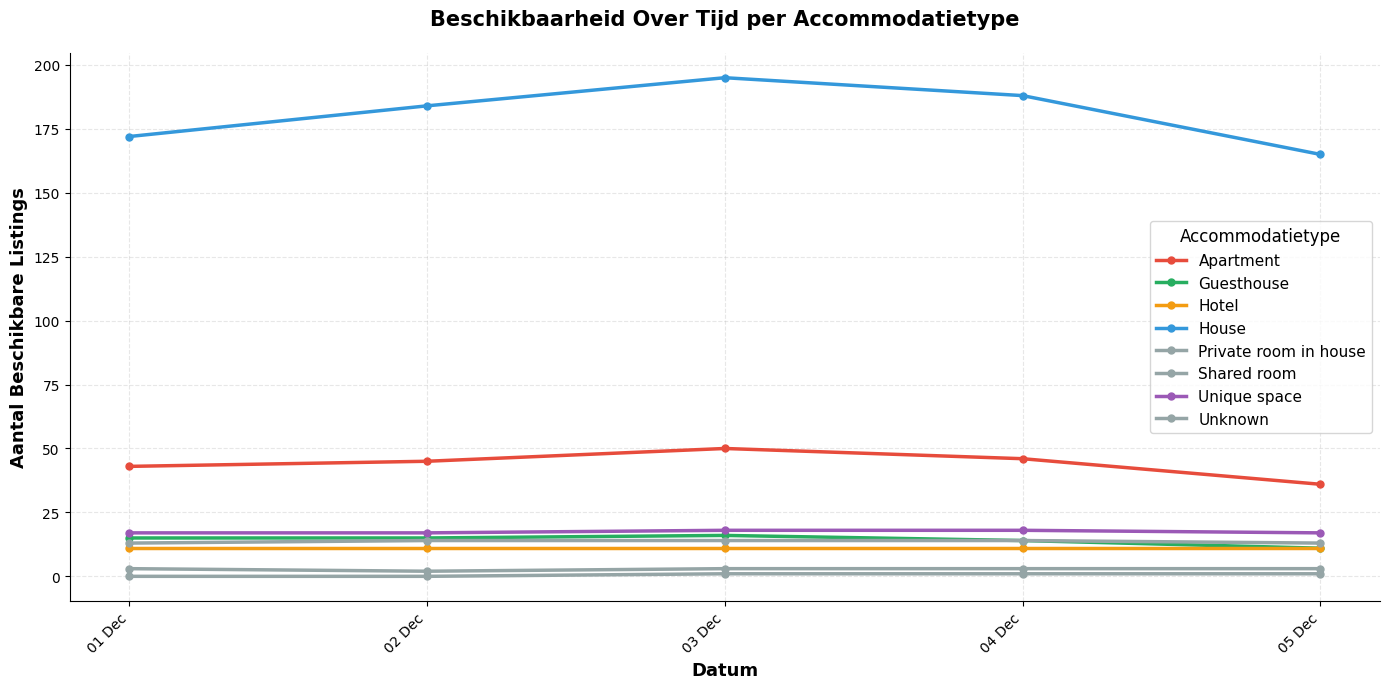


📊 Beschikbaarheid Statistieken per Type:

Apartment:
  • Gemiddeld: 44.0 listings/dag
  • Min: 36 listings
  • Max: 50 listings

Guesthouse:
  • Gemiddeld: 14.2 listings/dag
  • Min: 11 listings
  • Max: 16 listings

Hotel:
  • Gemiddeld: 11.0 listings/dag
  • Min: 11 listings
  • Max: 11 listings

House:
  • Gemiddeld: 180.8 listings/dag
  • Min: 165 listings
  • Max: 195 listings

Private room in house:
  • Gemiddeld: 2.8 listings/dag
  • Min: 2 listings
  • Max: 3 listings

Shared room:
  • Gemiddeld: 0.6 listings/dag
  • Min: 0 listings
  • Max: 1 listings

Unique space:
  • Gemiddeld: 17.4 listings/dag
  • Min: 17 listings
  • Max: 18 listings

Unknown:
  • Gemiddeld: 13.6 listings/dag
  • Min: 13 listings
  • Max: 14 listings


In [ ]:
# Maak timeline grafiek met visualization module
from src.visualization import create_availability_timeline_graph

# Bepaal periode (gebruik config of data)
period_start = PERIOD_START if 'PERIOD_START' in locals() else df_all['scan_checkin'].min()
period_end = PERIOD_END if 'PERIOD_END' in locals() else df_all['scan_checkout'].max()

# Maak timeline grafiek (slaat automatisch op in output_dir)
create_availability_timeline_graph(df_all, period_start, period_end, output_dir)
